In [1]:
!pip install sacremoses
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


In [2]:
import time
import re
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch
import numpy as np
import time
from tqdm import tqdm
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from typing import Dict, List, Set
from collections import defaultdict

# from grakel import graph_from_networkx
# from grakel.kernels import WeisfeilerLehman, VertexHistogram, ShortestPath, PyramidMatch

class GraphProcessor:
    """Optimized class for handling graph preprocessing and batch creation"""
    def __init__(self, min_freq: int = 7, chars_to_retain: int = 3):
        self.min_freq = min_freq
        self.chars_to_retain = chars_to_retain
        self.label_counts = defaultdict(int)
        self.final_labels: Set[str] = set()

    def preprocess_graphs(self, Gs: Dict[int, nx.DiGraph]) -> List[nx.DiGraph]:
        """
        Optimized graph preprocessing with better memory management and fewer iterations
        """
        processed_graphs = {}
        icd_pattern = re.compile(r"[A-TV-Z][0-9][0-9AB]\.?[0-9A-TV-Z]{0,4}")

        for idx, G in Gs.items():
            graph = G.copy()  # Create a copy to avoid modifying original
            to_remove = set()
            label_to_node = {}

            # Process nodes in a single pass
            for node in graph.nodes():
                node_data = graph.nodes[node]
                node_label = node_data.get("label", "")

                if node_label == "Condition":
                    self._process_condition_node(
                        graph, node, to_remove, label_to_node,
                        icd_pattern
                    )
                elif node_label == "MedicationRequest":
                    if not list(graph.successors(node)):
                        to_remove.add(node)

            # Remove nodes and update graph
            graph.remove_nodes_from(to_remove)
            processed_graphs[idx] = graph

            # Update label counts
            for node in graph.nodes():
                self.label_counts[graph.nodes[node].get("label", "")] += 1

        # Filter frequent labels
        self.final_labels = {
            label for label, count in self.label_counts.items()
            if count > self.min_freq
        }

        # Final graph refinement
        return self._refine_graphs(processed_graphs)

    def _process_condition_node(
        self,
        graph: nx.DiGraph,
        node: int,
        to_remove: Set[int],
        label_to_node: Dict[str, int],
        icd_pattern: re.Pattern
    ) -> None:
        """Process a single condition node"""
        successors = list(graph.successors(node))
        if len(successors) != 1:
            to_remove.add(node)
            return

        successor = successors[0]
        code = graph.nodes[successor].get("code", "")[:4]

        if not icd_pattern.match(code):
            to_remove.update({successor, node})
            return

        # Update node label
        new_label = code[:self.chars_to_retain]
        graph.nodes[successor]["label"] = new_label

        # Handle duplicate labels
        if new_label in label_to_node:
            if label_to_node[new_label] != successor:
                to_remove.add(successor)
                graph.add_edge(node, label_to_node[new_label])
        else:
            label_to_node[new_label] = successor

    def _refine_graphs(self, Gs: Dict[int, nx.DiGraph]) -> List[nx.DiGraph]:
        """Final refinement of graphs with optimized processing"""
        refined_graphs = []

        for G in Gs.values():
            nodes_to_remove = set()

            # Process nodes in a single pass
            for node in G.nodes():
                node_data = G.nodes[node]
                if node_data.get("label") in {"Condition"}:
                    predecessors = list(G.predecessors(node))
                    successors = list(G.successors(node))

                    if len(predecessors) != 1 or len(successors) != 1:
                        nodes_to_remove.add(node)
                        continue

                    # Check if successor's label is frequent enough
                    if G.nodes[successors[0]]["label"] in self.final_labels:
                        G.add_edge(predecessors[0], successors[0])
                    else:
                        nodes_to_remove.add(successors[0])
                    nodes_to_remove.add(node)

            # Remove nodes and add end node
            G.remove_nodes_from(nodes_to_remove)
            G.add_node("end_node", label="EndNode")

            # Find last encounter and connect to end node
            encounters = [
                node for node in G.nodes()
                if G.nodes[node]["label"] == "Encounter"
            ]
            subG = G.subgraph(encounters)
            last_encounter = next(
                node for node in encounters
                if len(list(subG.successors(node))) == 0
            )
            G.add_edge(last_encounter, "end_node")

            refined_graphs.append(G)

        return refined_graphs

In [3]:
import json
import torch
import numpy as np
import networkx as nx
from transformers import AutoTokenizer

class GraphBatch:
    def __init__(self, model="microsoft/BioGPT"):
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.node_label_mapping  = {"Patient": 0, "EndNode": 1, "Encounter": 2 }
        self.n_chain_labels = 3
        self.n_star_labels = 0

    def _extract_node_features(self, node_data: dict) -> torch.Tensor:
        node_data_str = json.dumps(node_data)
        tokenized = self.tokenizer(
            node_data_str,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )
        return tokenized['input_ids'].squeeze(0)

    def create_batches(self, Gs, batch_size, device, shuffle=False,n_star_labels=0):
        n_samples = len(Gs)
        idx = np.random.permutation(n_samples) if shuffle else np.arange(n_samples)

        edge_index_chain, edge_index_star, features_batch_list, label_batch_list = [], [], [], []
        last_node, node_indicator = [], []
        max_star, max_chain = 0, 0

        for i in range(0, n_samples, batch_size):
            Gs_batch, top_sort, last_node_batch = [], [], []
            n_nodes_batch, max_chain_batch = 0, 0

            for j in range(i, min(i + batch_size, n_samples)):
                nodes_in_chain = [
                    node for node in Gs[idx[j]].nodes()
                    if Gs[idx[j]].nodes[node]["label"] in [0, 1, 2]
                ]

                chain = Gs[idx[j]].subgraph(nodes_in_chain)
                ts = list(nx.topological_sort(chain))

                ts_processed, to_remove = [ts[0]], []
                for k in range(1, len(ts) - 1):
                    if Gs[idx[j]].out_degree(ts[k]) - 1 > 0:
                        ts_processed.append(ts[k])
                    else:
                        to_remove.append(ts[k])

                ts_processed.append(ts[-1])

                if to_remove:
                    for node in to_remove:
                        Gs[idx[j]].remove_node(node)
                    for k in range(len(ts_processed) - 1):
                        Gs[idx[j]].add_edge(ts_processed[k], ts_processed[k + 1])
                    ts = ts_processed

                for node in ts[1:-1]:
                    max_star = max(max_star, Gs[idx[j]].out_degree(node) - 1)

                mapping = {node: k + n_nodes_batch for k, node in enumerate(ts)}
                for node in Gs[idx[j]].nodes():
                    if node not in mapping:
                        mapping[node] = len(mapping) + n_nodes_batch

                G = nx.relabel_nodes(Gs[idx[j]], mapping)
                Gs_batch.append(G)
                ts = [k + n_nodes_batch for k in range(len(ts))]
                top_sort.append(ts)
                last_node_batch.append(ts[-1])
                max_chain_batch = max(max_chain_batch, len(ts))
                n_nodes_batch += G.number_of_nodes()

            max_chain = max(max_chain_batch, max_chain)

            try:
                features_batch = torch.zeros((n_nodes_batch, 512), dtype=torch.long)
                label_batch = torch.zeros(n_nodes_batch, dtype=torch.long)
                node_ind = torch.zeros(n_nodes_batch, dtype=torch.long)

                for j, G in enumerate(Gs_batch):
                    for node in G.nodes():
                        node_features = G.nodes[node]
                        node_feature_tensor = self._extract_node_features(node_features)
                        node_feature_tensor = node_feature_tensor[:512]
                        if node_feature_tensor.size(0) < 512:
                            padding_size = 512 - node_feature_tensor.size(0)
                            node_feature_tensor = torch.nn.functional.pad(
                                node_feature_tensor, (0, padding_size)
                            )
                        features_batch[node] = node_feature_tensor.long()
                        label_batch[node] = G.nodes[node]["label"]
                        node_ind[node] = j

                features_batch_list.append(features_batch.to(device))
                label_batch_list.append(label_batch.to(device))
                last_node.append(torch.LongTensor(last_node_batch).to(device))
                node_indicator.append(node_ind.to(device))

                edges_chain = [[] for _ in range(max_chain_batch - 1)]
                edges_star = [[] for _ in range(max_chain_batch - 1)]

                for j in range(max_chain_batch - 1):
                    for k in range(len(Gs_batch)):
                        if len(top_sort[k]) > j:
                            for successor in Gs_batch[k].successors(top_sort[k][j]):
                                if Gs_batch[k].nodes[successor]["label"] in [1, 2]:
                                    if not (j == 0 and successor != top_sort[k][j + 1]):
                                        edges_chain[j].append((top_sort[k][j], successor))
                                else:
                                    edges_star[j].append((successor, top_sort[k][j]))

                    edges_chain[j] = (
                        torch.LongTensor(np.vstack(edges_chain[j])).to(device)
                        if edges_chain[j]
                        else torch.empty((0, 2), dtype=torch.long).to(device)
                    )
                    edges_star[j] = (
                        torch.LongTensor(np.vstack(edges_star[j])).to(device)
                        if edges_star[j]
                        else torch.empty((0, 2), dtype=torch.long).to(device)
                    )

                edge_index_chain.append(edges_chain)
                edge_index_star.append(edges_star)

            except Exception as e:
                print(f"Error processing batch {i}: {str(e)}")
                continue


        return {
            'edge_index_chain': edge_index_chain,
            'edge_index_star': edge_index_star,
            'features': features_batch_list,
            'labels': label_batch_list,
            'node_indicator': node_indicator,
            'last_node': last_node,
            'max_chain': max_chain,
            'n_chain_labels': self.n_chain_labels,
            'n_star_labels': n_star_labels,
            'node_feature_dim': 512
        }


# Moldel

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
from torch_geometric.nn import GCNConv
from typing import List, Tuple, Optional, Dict, Any


class NeuralNet(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        latent_dim: int,
        max_chain: int,
        n_chain_labels: int,
        n_star_labels: int,
        node_feature_dim: int,
        device: torch.device,
        dropout_rate: float = 0.2
    ):
        """
        Initialize the neural network model.

        Args:
            hidden_dim: Dimension of hidden layers
            latent_dim: Dimension of latent space
            max_chain: Maximum length of chain in graph
            n_chain_labels: Number of chain node labels
            n_star_labels: Number of star node labels
            node_feature_dim: Dimension of node features
            device: torch device to use
            dropout_rate: Dropout rate for regularization
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.device = device
        self.max_chain = max_chain
        self.n_chain_labels = n_chain_labels
        self.n_star_labels = n_star_labels
        self.node_feature_dim = node_feature_dim

        # Node feature processing
        self.feature_encoder = nn.Sequential(
            nn.Linear(node_feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Label embedding layer
        self.label_embedding = nn.Embedding(n_chain_labels + n_star_labels, hidden_dim)

        # Combined feature processing
        self.feature_combiner = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Graph convolution layers with residual connections
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        # Encoder
        self.gru_enc = nn.GRUCell(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.gru_dec = nn.GRUCell(hidden_dim, hidden_dim)
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Node type prediction
        self.add_node_chain = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 3),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 3, n_chain_labels - 1)
        )

        # Star node prediction
        self.add_node_star = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 6),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 6, n_star_labels)
        )

        # Feature decoder
        self.feature_decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, node_feature_dim)
        )

    def encode(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,  # Added this parameter
        last_node: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode the input graph into latent space.

        Args:
            edge_index_chain: List of edge indices for chain connections
            edge_index_star: List of edge indices for star connections
            x: Node labels
            node_features: Node feature matrix
            node_indicator: Batch assignment of nodes
            last_node: Index of the last node in each graph

        Returns:
            Tuple of (mu, logvar) for the latent distribution
        """
        last_node = last_node.to(torch.int64)
        batch_size = x.size(0)
        h = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        m = torch.zeros(batch_size, self.hidden_dim, device=self.device)

        # Process node features and labels
        encoded_features = self.feature_encoder(node_features.float())
        label_embeddings = self.label_embedding(x)
        combined_features = self.feature_combiner(
            torch.cat([encoded_features, label_embeddings], dim=-1))

        # Process star nodes with residual connections
        for i in range(1, len(edge_index_star)):
            if edge_index_star[i] is not None and edge_index_star[i].size(0) > 0:
                unique = torch.unique(edge_index_star[i][:, 1])

                # Aggregate features
                h.scatter_add_(
                    0,
                    edge_index_star[i][:, 1].unsqueeze(1).expand(-1, self.hidden_dim).long(),
                    combined_features[edge_index_star[i][:, 0].long()]
                )


                unique = unique.long()  # Convert indices to torch.long
                h[unique] = self.gru_enc(combined_features[unique].float(), h[unique])

                # Apply graph convolutions with residual connections
                edge_index_star[i] = edge_index_star[i].to(torch.int64)
                h_conv = self.conv1(h, edge_index_star[i].T)
                h_conv = F.relu(h_conv)
                h_conv = self.conv2(h_conv, edge_index_star[i].T)
                h = self.layer_norm(h + h_conv)

        # Process chain nodes
        for edge_index in edge_index_chain:
            if edge_index is not None and edge_index.size(0) > 0:
                unique = torch.unique(edge_index[:, 0]).to(torch.int64)
                h[unique] = self.gru_enc(h[unique], m[unique])
                m[edge_index[:, 1].to(torch.int64)] += h[edge_index[:, 0].to(torch.int64)]

        # Process final node
        h[last_node] = self.gru_enc(combined_features[last_node], m[last_node])
        h_g = h[last_node]

        # Generate latent distribution parameters
        return self.fc_mu(h_g), self.fc_logvar(h_g)


    def reparameterize(
        self,
        mu: torch.Tensor,
        logvar: torch.Tensor,
        eps_scale: float = 1.0
    ) -> torch.Tensor:
        """
        Perform reparameterization trick to sample from latent distribution.
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std) * eps_scale
            return mu + eps * std
        return mu



    def decode(
        self,
        z: torch.Tensor,
        stochastic: bool = True
    ) -> List[nx.DiGraph]:
        """
        Decode latent vectors into graphs.

        Args:
            z: Latent vectors
            stochastic: Whether to use stochastic sampling

        Returns:
            List of reconstructed graphs
        """
        # Initialize hidden state from latent vector
        h0 = self.fc_decoder(z)  # Shape: [batch_size, hidden_dim]
        batch_size = z.size(0)

        # Initialize graphs
        Gs_reconstructed = [nx.DiGraph() for _ in range(batch_size)]
        for G in Gs_reconstructed:
            G.add_node(0, label=0, features=torch.zeros(self.node_feature_dim, device=self.device))

        # Initialize states
        node_labels = torch.zeros(batch_size, dtype=torch.long, device=self.device)
        x = self.label_embedding(node_labels)  # Shape: [batch_size, hidden_dim]
        h = self.gru_dec(x.float(), h0.float())  # Initial hidden state

        # Generate initial features
        initial_features = self.feature_decoder(h)
        for i, G in enumerate(Gs_reconstructed):
            G.nodes[0]["features"] = initial_features[i].detach()

        active_graphs = [True] * batch_size

        # Generate graph structure
        for node_idx in range(1, self.max_chain):
            active_indices = [i for i, active in enumerate(active_graphs) if active]
            if not active_indices:
                break

            # Generate node labels
            if node_idx == self.max_chain - 1:
                new_node_labels = [0] * len(active_indices)  # End node labels
            else:
                # Generate hidden states for active graphs
                active_labels = torch.tensor([
                    Gs_reconstructed[i].nodes[node_idx - 1]["label"]
                    for i in active_indices
                ], dtype=torch.long, device=self.device)

                # Get embeddings for active labels
                active_embeddings = self.label_embedding(active_labels)  # Shape: [num_active, hidden_dim]
                active_h0 = h0[active_indices]  # Shape: [num_active, hidden_dim]

                h_graph = self.gru_dec(active_embeddings.float(), active_h0.float())

                # Predict next node labels
                node_label_scores = self.add_node_chain(h_graph)
                if stochastic:
                    probs = F.softmax(node_label_scores, dim=1)
                    new_node_labels = torch.multinomial(probs, 1).flatten().tolist()
                else:
                    new_node_labels = torch.argmax(node_label_scores, dim=1).tolist()

            # Add nodes and edges
            for idx, i in enumerate(active_indices):
                G = Gs_reconstructed[i]
                label = new_node_labels[idx] + 1  # Adjust label indexing
                G.add_node(node_idx, label=label)
                G.add_edge(node_idx - 1, node_idx)

                # Generate features for the new node
                label_tensor = torch.tensor([label], device=self.device)
                label_embedding = self.label_embedding(label_tensor)  # Shape: [1, hidden_dim]
                h_node = self.gru_dec(
                    label_embedding.float(),
                    h0[i:i+1].float()  # Shape: [1, hidden_dim]
                )
                G.nodes[node_idx]["features"] = self.feature_decoder(h_node).detach().squeeze(0)

                # Check if the graph becomes inactive
                if label == 1:  # End node
                    active_graphs[i] = False
                else:
                    G.add_edge(0, node_idx)  # Add edge to start node for non-end nodes

            # Generate star nodes
            active_indices = [i for i, active in enumerate(active_graphs) if active]
            if active_indices:
                # Get labels for active nodes
                active_labels = torch.tensor([
                    Gs_reconstructed[i].nodes[node_idx]["label"]
                    for i in active_indices
                ], dtype=torch.long, device=self.device)

                # Get embeddings and hidden states
                active_embeddings = self.label_embedding(active_labels)  # Shape: [num_active, hidden_dim]
                active_h0 = h0[active_indices]  # Shape: [num_active, hidden_dim]

                h_nodes = self.gru_dec(active_embeddings.float(), active_h0.float())

                edge_probs = torch.sigmoid(self.add_node_star(h_nodes))
                if stochastic:
                    star_decisions = (edge_probs > torch.rand_like(edge_probs)).cpu()
                else:
                    star_decisions = (edge_probs > 0.5).cpu()

                # Add star nodes and edges
                for idx, i in enumerate(active_indices):
                    G = Gs_reconstructed[i]
                    for j, add_star in enumerate(star_decisions[idx]):
                        if add_star:
                            star_idx = self.max_chain + j
                            if not G.has_node(star_idx):
                                star_label = j + self.n_chain_labels
                                G.add_node(star_idx, label=star_label)

                                # Generate features for star nodes
                                star_label_tensor = torch.tensor([star_label], device=self.device)
                                star_embedding = self.label_embedding(star_label_tensor)
                                star_state = self.gru_dec(
                                    star_embedding.float(),
                                    h_nodes[idx:idx+1].float()
                                )
                                G.nodes[star_idx]["features"] = self.feature_decoder(star_state).detach().squeeze(0)

                            G.add_edge(node_idx, star_idx)

        return Gs_reconstructed



    def loss(
        self,
        mu: torch.Tensor,
        logvar: torch.Tensor,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_ind: torch.Tensor,
        beta: float = 1.0
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Calculate the total loss for training.

        Args:
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution
            edge_index_chain: List of edge indices for chain connections
            edge_index_star: List of edge indices for star connections
            x: Node labels
            node_features: Node feature matrix
            node_ind: Node indicators
            beta: Weight for KL divergence term

        Returns:
            Tuple of (total_loss, negative_log_likelihood, KL_divergence, feature_reconstruction_loss)
        """
        z = self.reparameterize(mu, logvar)
        h0 = self.fc_decoder(z)
        node_ind = node_ind.to(torch.int64)

        # Process features
        h_nodes = self.feature_combiner(
            torch.cat([
                self.feature_encoder(node_features),
                self.label_embedding(x)
            ], dim=-1)
        )

        # Initialize states
        unique = torch.unique(edge_index_chain[0][:, 0]).to(torch.int64)  # Ensure correct indexing type
        h_nodes[unique,:] = self.gru_dec(h_nodes[unique], h0)
        h_graph = torch.zeros(z.size(0), self.hidden_dim, device=z.device)
        h_graph[node_ind[unique]] = h_nodes[unique,:]

        # Initialize loss components
        nll = torch.tensor(0.0, device=z.device)
        feature_recon_loss = torch.tensor(0.0, device=z.device)

        for node_idx, edge_index in enumerate(edge_index_chain):
            if edge_index is None or len(edge_index) == 0:
                continue

            # Node prediction loss
            unique_prev = torch.unique(edge_index[:, 0])
            unique_prev = unique_prev.to(torch.int64)
            h_graph = h_graph.to(torch.float32)
            node_scores = self.add_node_chain(h_graph[node_ind[unique_prev],:])


            unique = torch.unique(edge_index_chain[node_idx][:, 1]).to(torch.long)
            target = (x[unique] - 1).to(torch.int64)
            nll += F.cross_entropy(node_scores, target, reduction="sum")

            # Feature reconstruction loss
            pred_features = self.feature_decoder(h_nodes[unique])
            feature_recon_loss += F.mse_loss(
                pred_features,
                node_features[unique],
                reduction="sum"
            )

            # Update states
            h_nodes[unique] = self.gru_dec(h_nodes[unique], h_nodes[unique_prev])

            # Process star nodes
            if node_idx + 1 < len(edge_index_star):
                star_edge_index = edge_index_star[node_idx + 1]
                if star_edge_index is not None and len(star_edge_index) > 0:
                    chain_nodes = unique[x[unique] != 1]
                    if len(chain_nodes) > 0:
                        edge_probs = self.add_node_star(h_nodes[chain_nodes])

                        # Create target tensor for star nodes
                        star_unique = torch.unique(star_edge_index[:, 1])
                        target = torch.zeros(
                            len(star_unique),
                            self.n_star_labels,
                            device=z.device
                        )

                        for idx, node in enumerate(star_unique):
                            edges_to_node = star_edge_index[star_edge_index[:, 1] == node]
                            star_labels = x[edges_to_node[:, 0]] - self.n_chain_labels
                            target[idx].scatter_(0, star_labels, 1)

                        # Calculate star node loss
                        nll += F.binary_cross_entropy_with_logits(
                            edge_probs,
                            target,
                            reduction="sum"
                        )

                        # Update node states with star information
                        m = torch.zeros_like(h_nodes)
                        m.scatter_add_(
                            0,
                            star_edge_index[:, 1].unsqueeze(1).expand(-1, self.hidden_dim),
                            h_nodes[star_edge_index[:, 0]]
                        )
                        h_nodes[star_unique] = self.gru_dec(h_nodes[star_unique], m[star_unique])

            h_graph[node_ind[unique]] = h_nodes[unique]

        # Calculate KL divergence
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Compute total loss with weighted components
        total_loss = nll + beta * kld + 0.1 * feature_recon_loss

        return total_loss, nll, kld, feature_recon_loss

    def encode_decode(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,
        last_node: torch.Tensor,
    ) -> List[nx.DiGraph]:
        """
        Encode and decode a graph in a deterministic manner.
        """
        mu, logvar = self.encode(
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator,
            last_node
        )
        z = self.reparameterize(mu, logvar)
        return self.decode(z, stochastic=False)

    def perturb(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,
        last_node: torch.Tensor,
        eps_scale: float = 5.0
    ) -> List[nx.DiGraph]:
        """
        Generate perturbed versions of input graphs.
        """
        mu, logvar = self.encode(
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator,
            last_node
        )
        z = mu + eps_scale * torch.randn_like(mu)
        return self.decode(z)

    def forward(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,
        last_node: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass through the model.
        """
        mu, logvar = self.encode(
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator,
            last_node
        )
        loss, _, _, _ = self.loss(
            mu,
            logvar,
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator
        )
        return loss

    def generate_sample(self, n: int) -> List[nx.DiGraph]:
        """
        Generate n random graph samples from the prior distribution.

        Args:
            n: Number of samples to generate

        Returns:
            List of generated graphs
        """
        z = torch.randn(n, self.latent_dim, device=self.device)
        return self.decode(z, stochastic=True)

    def generate_node_features(self, h: torch.Tensor) -> torch.Tensor:
        """
        Generate node features from hidden state.

        Args:
            h: Hidden state tensor

        Returns:
            Generated node features
        """
        return self.feature_decoder(h)

    def save_model(self, path: str) -> None:
        """
        Save model state to file.
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            'model_config': {
                'hidden_dim': self.hidden_dim,
                'latent_dim': self.latent_dim,
                'max_chain': self.max_chain,
                'n_chain_labels': self.n_chain_labels,
                'n_star_labels': self.n_star_labels,
                'node_feature_dim': self.node_feature_dim
            }
        }, path)

    @classmethod
    def load_model(cls, path: str, device: torch.device) -> 'NeuralNet':
        """
        Load model from file.

        Args:
            path: Path to saved model file
            device: torch device to load model onto

        Returns:
            Loaded model instance
        """
        checkpoint = torch.load(path, map_location=device)
        model = cls(
            hidden_dim=checkpoint['model_config']['hidden_dim'],
            latent_dim=checkpoint['model_config']['latent_dim'],
            max_chain=checkpoint['model_config']['max_chain'],
            n_chain_labels=checkpoint['model_config']['n_chain_labels'],
            n_star_labels=checkpoint['model_config']['n_star_labels'],
            node_feature_dim=checkpoint['model_config']['node_feature_dim'],
            device=device
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        return model

    def get_evaluation_metrics(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,
        last_node: torch.Tensor
    ) -> Dict[str, float]:
        """
        Calculate evaluation metrics for the model.

        Returns:
            Dictionary containing evaluation metrics
        """
        mu, logvar = self.encode(
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator,
            last_node
        )

        total_loss, nll, kld, feature_loss = self.loss(
            mu,
            logvar,
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator
        )

        return {
            'total_loss': total_loss.item(),
            'negative_log_likelihood': nll.item(),
            'kl_divergence': kld.item(),
            'feature_reconstruction_loss': feature_loss.item(),
            'avg_mu': mu.mean().item(),
            'avg_logvar': logvar.mean().item(),
        }

# code

In [5]:
import pickle
with open('/content/graph_dict.pkl', 'rb') as file:
    data = pickle.load(file)
values_list = list(data.values())

print(values_list)


[<networkx.classes.digraph.DiGraph object at 0x7c0307ad4940>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad6620>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad5b10>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad5a50>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad49d0>, <networkx.classes.digraph.DiGraph object at 0x7c02e6d3d630>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad4970>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad5480>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad5510>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad5d80>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad5de0>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad5360>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad53c0>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad6140>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad6530>, <networkx.classes.digraph.DiGraph object at 0x7c0307ad58a0>, <networkx.classes.digra

In [6]:
processor = GraphProcessor(min_freq=10)
Gs = processor.preprocess_graphs(data)

mapping = {"Patient": 0, "EndNode": 1, "Encounter": 2,"EncounterType":3,"EncounterCategory":4, 'MedicationRequest': 5, 'MedicationType':6 }
for G in Gs:
    for node in G.nodes():
        if G.nodes[node]["label"] not in mapping:
            mapping[G.nodes[node]["label"]] = len(mapping)
        G.nodes[node]["label"] = mapping[G.nodes[node]["label"]]

inv_mapping = dict()
for k, v in mapping.items():
    inv_mapping[v] = k
inv_mapping

{0: 'Patient',
 1: 'EndNode',
 2: 'Encounter',
 3: 'EncounterType',
 4: 'EncounterCategory',
 5: 'MedicationRequest',
 6: 'MedicationType',
 7: 'V15',
 8: 'V49',
 9: 'Y92',
 10: 'D69',
 11: 'Z68',
 12: 'D62',
 13: 'E87',
 14: 'Z66',
 15: 'I48',
 16: 'I95',
 17: 'V58',
 18: 'V12',
 19: 'E88',
 20: 'E93',
 21: 'V10',
 22: 'N18',
 23: 'E11',
 24: 'E78',
 25: 'N17',
 26: 'Z79',
 27: 'Z87',
 28: 'F41',
 29: 'Z95',
 30: 'Z85',
 31: 'K21',
 32: 'V45',
 33: 'E84',
 34: 'J96',
 35: 'I25',
 36: 'I50',
 37: 'G47',
 38: 'I10'}

In [7]:
n_chain_labels = 3
n_star_labels = len(mapping) - n_chain_labels
print(n_star_labels)

36


In [8]:
Gs[0].nodes(data=True)

NodeDataView({'4122723': {'label': 0, 'identifier': '10000032', 'race': 'White', 'gender': 'F', 'id': '0a8eebfd-a352-522e-89f0-1d4a13abdebc', 'birthDate': '2128-05-06', 'nodeId': '4122723', 'yearOfDeath': '2180-09-09'}, '5490544': {'label': 2, 'start': '2180-05-06T22:23:00.000000000-04:00', 'end': '2180-05-07T17:15:00.000000000-04:00', 'id': '9c4ef2ae-dd61-5efe-885d-2a2f0816646f', 'nodeId': '5490544'}, '3905590': {'label': 3, 'code': '453701000124103', 'type': 'In-person encounter (procedure)', 'nodeId': '3905590'}, '5955430': {'label': 4, 'category': 'URGENT', 'nodeId': '5955430'}, '6276843': {'label': 5, 'dosage': '0.5 mL Syringe', 'authoredOn': '2180-05-07T00:00:54.000000000-04:00', 'route': 'IM', 'doseQuantity': 0.5, 'id': '327ac3e9-051b-5382-b002-76bf9acdad81', 'nodeId': '6276843', 'status': 'completed', 'doseUnit': 'mL'}, '9400787': {'label': 6, 'drugCode': 'INFL0.5LF', 'name': 'Influenza Vaccine Quadrivalent', 'id': '1208f5c2-4962-563c-9692-8d74009dfd93', 'ndc': '19515089452', '

In [9]:
def train_model(model, edge_index_chain, edge_index_star, features_batch_list, x, node_indicator, last_node,
                epochs=100, learning_rate=0.1, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
    best_loss = float('inf')
    n_batches = len(features_batch_list)

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        epoch_stats = {
            'total_loss': 0.0,
            'nll_loss': 0.0,
            'kld_loss': 0.0,
            'feature_loss': 0.0,
            'n_samples': 0
        }

        # Process each batch
        for batch_idx in tqdm(range(n_batches), desc=f'Epoch {epoch}/{epochs}'):
            optimizer.zero_grad()

            # Get batch data
            batch_edge_index_chain = edge_index_chain[batch_idx]
            batch_edge_index_star = edge_index_star[batch_idx]
            batch_x = x[batch_idx]
            batch_features = features_batch_list[batch_idx]
            batch_node_indicator = node_indicator[batch_idx]
            batch_last_node = last_node[batch_idx]

            # Forward pass
            mu, logvar = model.encode(
                edge_index_chain=batch_edge_index_chain,
                edge_index_star=batch_edge_index_star,
                x=batch_x,
                node_features=batch_features,
                node_indicator=batch_node_indicator,
                last_node=batch_last_node
            )

            # Calculate loss
            total_loss, nll, kld, feature_loss = model.loss(
                mu=mu,
                logvar=logvar,
                edge_index_chain=batch_edge_index_chain,
                edge_index_star=batch_edge_index_star,
                x=batch_x,
                node_features=batch_features,
                node_ind=batch_node_indicator,
                beta=1.0
            )

            # Backward pass
            total_loss.backward()
            optimizer.step()

            # Update statistics
            batch_size = len(batch_x)
            epoch_stats['total_loss'] += float(total_loss)
            epoch_stats['nll_loss'] += float(nll)
            epoch_stats['kld_loss'] += float(kld)
            epoch_stats['feature_loss'] += float(feature_loss)
            epoch_stats['n_samples'] += batch_size

        scheduler.step()

        # Calculate and print average losses
        avg_total_loss = epoch_stats['total_loss'] / epoch_stats['n_samples']
        avg_nll_loss = epoch_stats['nll_loss'] / epoch_stats['n_samples']
        avg_kld_loss = epoch_stats['kld_loss'] / epoch_stats['n_samples']
        avg_feature_loss = epoch_stats['feature_loss'] / epoch_stats['n_samples']
        epoch_time = time.time() - start_time

        print(f"Epoch: {epoch:04d}")
        print(f"  Total Loss: {avg_total_loss:.6f}")
        print(f"  NLL Loss: {avg_nll_loss:.6f}")
        print(f"  KLD Loss: {avg_kld_loss:.6f}")
        print(f"  Feature Loss: {avg_feature_loss:.6f}")
        print(f"  Time: {epoch_time:.2f}s")

        if avg_total_loss < best_loss:
            best_loss = avg_total_loss
            print("  Saving new best model...")
            model.save_model('best_model.pt')

        if epoch % 10 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_loss': best_loss,
            }
            torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{epoch}.pt')

    return model, best_loss

In [10]:
def train_pipeline(model, batch_data, epochs=100, learning_rate=0.001, device='cuda'):

    # Convert features and edge indices to float32
    batch_data['features'] = [f.float().to(device) for f in batch_data['features']]
    batch_data['edge_index_chain'] = [[e.float().to(device) for e in edges] for edges in batch_data['edge_index_chain']]
    batch_data['edge_index_star'] = [[e.float().to(device) for e in edges] for edges in batch_data['edge_index_star']]
    batch_data['node_indicator'] = [ni.float().to(device) for ni in batch_data['node_indicator']]
    batch_data['last_node'] = [ln.float().to(device) for ln in batch_data['last_node']]


    model = model.to(device)
    model, best_loss = train_model(
        model=model,
        edge_index_chain=batch_data['edge_index_chain'],
        edge_index_star=batch_data['edge_index_star'],
        features_batch_list=batch_data['features'],
        x=batch_data['labels'],
        node_indicator=batch_data['node_indicator'],
        last_node=batch_data['last_node'],
        epochs=epochs,
        learning_rate=learning_rate,
        device=device
    )
    return model, best_loss

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph_batcher = GraphBatch()
batch_data = graph_batcher.create_batches(
    Gs,
    batch_size=20,
    device=device,
    shuffle=True,
    n_star_labels=n_star_labels)

In [16]:
print(batch_data['n_star_labels'])
print(batch_data['max_chain'])

36
22


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet(
    hidden_dim=2048,
    latent_dim=1024,
    max_chain=batch_data['max_chain'],
    n_chain_labels=batch_data['n_chain_labels'],
    n_star_labels=batch_data['n_star_labels'],
    node_feature_dim=batch_data['node_feature_dim'],
    device=device,
    dropout_rate=0.2
).to(device)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, best_loss = train_pipeline(model, batch_data, epochs=100, learning_rate=0.00001, device=device)

Epoch 1/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0001
  Total Loss: 4885824.763806
  NLL Loss: 95.867725
  KLD Loss: 0.582074
  Feature Loss: 48857282.790943
  Time: 6.19s
  Saving new best model...


Epoch 2/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0002
  Total Loss: 4859863.666379
  NLL Loss: 66.084812
  KLD Loss: 0.579984
  Feature Loss: 48597967.720470
  Time: 6.22s
  Saving new best model...


Epoch 3/100: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch: 0003
  Total Loss: 4837214.572582
  NLL Loss: 66.757846
  KLD Loss: 0.581989
  Feature Loss: 48371471.949902
  Time: 6.55s
  Saving new best model...


Epoch 4/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0004
  Total Loss: 4813727.487408
  NLL Loss: 65.900194
  KLD Loss: 0.578465
  Feature Loss: 48136608.347053
  Time: 6.24s
  Saving new best model...


Epoch 5/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0005
  Total Loss: 4788744.062077
  NLL Loss: 61.774586
  KLD Loss: 0.589786
  Feature Loss: 47886816.471934
  Time: 6.30s
  Saving new best model...


Epoch 6/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0006
  Total Loss: 4764263.505922
  NLL Loss: 61.384232
  KLD Loss: 0.590953
  Feature Loss: 47642016.300585
  Time: 6.29s
  Saving new best model...


Epoch 7/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0007
  Total Loss: 4737309.588056
  NLL Loss: 61.671108
  KLD Loss: 0.592293
  Feature Loss: 47372472.475201
  Time: 6.29s
  Saving new best model...


Epoch 8/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0008
  Total Loss: 4709225.864138
  NLL Loss: 54.859361
  KLD Loss: 0.597191
  Feature Loss: 47091703.635885
  Time: 6.32s
  Saving new best model...


Epoch 9/100: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch: 0009
  Total Loss: 4679145.625993
  NLL Loss: 57.101388
  KLD Loss: 0.600946
  Feature Loss: 46790877.277306
  Time: 6.42s
  Saving new best model...


Epoch 10/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0010
  Total Loss: 4646601.319599
  NLL Loss: 54.719500
  KLD Loss: 0.597193
  Feature Loss: 46465457.447021
  Time: 6.34s
  Saving new best model...


Epoch 11/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0011
  Total Loss: 4612897.375142
  NLL Loss: 53.902946
  KLD Loss: 0.597198
  Feature Loss: 46128427.481781
  Time: 6.23s
  Saving new best model...


Epoch 12/100: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch: 0012
  Total Loss: 4574309.623996
  NLL Loss: 51.182592
  KLD Loss: 0.602924
  Feature Loss: 45742578.594183
  Time: 6.39s
  Saving new best model...


Epoch 13/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0013
  Total Loss: 4535330.153469
  NLL Loss: 52.830604
  KLD Loss: 0.602424
  Feature Loss: 45352766.974815
  Time: 6.28s
  Saving new best model...


Epoch 14/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0014
  Total Loss: 4489718.590371
  NLL Loss: 56.711870
  KLD Loss: 0.604035
  Feature Loss: 44896611.939556
  Time: 6.29s
  Saving new best model...


Epoch 15/100: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch: 0015
  Total Loss: 4438554.834869
  NLL Loss: 59.964723
  KLD Loss: 0.609976
  Feature Loss: 44384942.972637
  Time: 6.39s
  Saving new best model...


Epoch 16/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0016
  Total Loss: 4384905.125017
  NLL Loss: 59.838190
  KLD Loss: 0.619778
  Feature Loss: 43848444.851840
  Time: 6.32s
  Saving new best model...


Epoch 17/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0017
  Total Loss: 4327567.816309
  NLL Loss: 63.221441
  KLD Loss: 0.621024
  Feature Loss: 43275038.308300
  Time: 6.25s
  Saving new best model...


Epoch 18/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0018
  Total Loss: 4268938.995326
  NLL Loss: 60.071783
  KLD Loss: 0.623413
  Feature Loss: 42688782.253846
  Time: 6.31s
  Saving new best model...


Epoch 19/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0019
  Total Loss: 4211586.259473
  NLL Loss: 58.414359
  KLD Loss: 0.628245
  Feature Loss: 42115270.880065
  Time: 6.28s
  Saving new best model...


Epoch 20/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0020
  Total Loss: 4148664.602986
  NLL Loss: 56.048079
  KLD Loss: 0.625854
  Feature Loss: 41486079.035803
  Time: 6.18s
  Saving new best model...


Epoch 21/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0021
  Total Loss: 4086553.522167
  NLL Loss: 58.129629
  KLD Loss: 0.626738
  Feature Loss: 40864947.224395
  Time: 6.28s
  Saving new best model...


Epoch 22/100: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch: 0022
  Total Loss: 4025678.192857
  NLL Loss: 55.774833
  KLD Loss: 0.630681
  Feature Loss: 40256217.350819
  Time: 6.47s
  Saving new best model...


Epoch 23/100: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch: 0023
  Total Loss: 3963873.145709
  NLL Loss: 49.958735
  KLD Loss: 0.626837
  Feature Loss: 39638225.985751
  Time: 6.53s
  Saving new best model...


Epoch 24/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0024
  Total Loss: 3895608.074420
  NLL Loss: 53.533764
  KLD Loss: 0.629348
  Feature Loss: 38955538.006081
  Time: 6.37s
  Saving new best model...


Epoch 25/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0025
  Total Loss: 3839863.618460
  NLL Loss: 54.163820
  KLD Loss: 0.626947
  Feature Loss: 38398087.963334
  Time: 6.31s
  Saving new best model...


Epoch 26/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0026
  Total Loss: 3778519.991650
  NLL Loss: 52.932695
  KLD Loss: 0.624574
  Feature Loss: 37784663.776739
  Time: 6.29s
  Saving new best model...


Epoch 27/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0027
  Total Loss: 3723988.378817
  NLL Loss: 54.583244
  KLD Loss: 0.630575
  Feature Loss: 37239330.920180
  Time: 6.28s
  Saving new best model...


Epoch 28/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0028
  Total Loss: 3663931.524618
  NLL Loss: 51.390699
  KLD Loss: 0.629540
  Feature Loss: 36638794.161819
  Time: 6.20s
  Saving new best model...


Epoch 29/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0029
  Total Loss: 3610440.314743
  NLL Loss: 52.829805
  KLD Loss: 0.629038
  Feature Loss: 36103867.751146
  Time: 6.21s
  Saving new best model...


Epoch 30/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0030
  Total Loss: 3557705.220856
  NLL Loss: 49.258426
  KLD Loss: 0.629753
  Feature Loss: 35576552.313291
  Time: 6.28s
  Saving new best model...


Epoch 31/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0031
  Total Loss: 3509366.631030
  NLL Loss: 50.681381
  KLD Loss: 0.628768
  Feature Loss: 35093152.196034
  Time: 6.28s
  Saving new best model...


Epoch 32/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0032
  Total Loss: 3466585.949086
  NLL Loss: 49.122477
  KLD Loss: 0.630672
  Feature Loss: 34665361.175478
  Time: 6.21s
  Saving new best model...


Epoch 33/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0033
  Total Loss: 3419845.741616
  NLL Loss: 49.520350
  KLD Loss: 0.626550
  Feature Loss: 34197955.476335
  Time: 6.23s
  Saving new best model...


Epoch 34/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0034
  Total Loss: 3377424.856015
  NLL Loss: 48.214764
  KLD Loss: 0.626397
  Feature Loss: 33773759.909970
  Time: 6.31s
  Saving new best model...


Epoch 35/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0035
  Total Loss: 3341161.492399
  NLL Loss: 52.360792
  KLD Loss: 0.626367
  Feature Loss: 33411084.824976
  Time: 6.30s
  Saving new best model...


Epoch 36/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0036
  Total Loss: 3306309.015565
  NLL Loss: 47.120540
  KLD Loss: 0.628891
  Feature Loss: 33062612.007079
  Time: 6.33s
  Saving new best model...


Epoch 37/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0037
  Total Loss: 3271291.951536
  NLL Loss: 46.255146
  KLD Loss: 0.628373
  Feature Loss: 32712450.381449
  Time: 6.30s
  Saving new best model...


Epoch 38/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0038
  Total Loss: 3245617.603848
  NLL Loss: 47.845992
  KLD Loss: 0.632755
  Feature Loss: 32455690.269274
  Time: 6.21s
  Saving new best model...


Epoch 39/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0039
  Total Loss: 3215026.039479
  NLL Loss: 48.702961
  KLD Loss: 0.629575
  Feature Loss: 32149767.004946
  Time: 6.29s
  Saving new best model...


Epoch 40/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0040
  Total Loss: 3193988.989427
  NLL Loss: 46.288003
  KLD Loss: 0.630145
  Feature Loss: 31939420.667423
  Time: 6.21s
  Saving new best model...


Epoch 41/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0041
  Total Loss: 3165683.848800
  NLL Loss: 47.678469
  KLD Loss: 0.628159
  Feature Loss: 31656354.112810
  Time: 6.28s
  Saving new best model...


Epoch 42/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0042
  Total Loss: 3145929.110496
  NLL Loss: 45.832665
  KLD Loss: 0.627807
  Feature Loss: 31458824.573218
  Time: 6.23s
  Saving new best model...


Epoch 43/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0043
  Total Loss: 3125184.757998
  NLL Loss: 41.741373
  KLD Loss: 0.629690
  Feature Loss: 31251423.519354
  Time: 6.34s
  Saving new best model...


Epoch 44/100: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch: 0044
  Total Loss: 3106781.521260
  NLL Loss: 42.117250
  KLD Loss: 0.632844
  Feature Loss: 31067386.226437
  Time: 6.39s
  Saving new best model...


Epoch 45/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0045
  Total Loss: 3088122.574942
  NLL Loss: 42.194590
  KLD Loss: 0.632137
  Feature Loss: 30880797.320869
  Time: 6.30s
  Saving new best model...


Epoch 46/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0046
  Total Loss: 3070458.354222
  NLL Loss: 42.042508
  KLD Loss: 0.624583
  Feature Loss: 30704155.764215
  Time: 6.24s
  Saving new best model...


Epoch 47/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0047
  Total Loss: 3059417.954894
  NLL Loss: 43.774529
  KLD Loss: 0.626785
  Feature Loss: 30593734.949766
  Time: 6.30s
  Saving new best model...


Epoch 48/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0048
  Total Loss: 3041355.881109
  NLL Loss: 42.181734
  KLD Loss: 0.632514
  Feature Loss: 30413130.289604
  Time: 6.21s
  Saving new best model...


Epoch 49/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0049
  Total Loss: 3031062.257839
  NLL Loss: 45.166208
  KLD Loss: 0.639663
  Feature Loss: 30310164.317829
  Time: 6.18s
  Saving new best model...


Epoch 50/100: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch: 0050
  Total Loss: 3015924.929165
  NLL Loss: 43.034171
  KLD Loss: 0.664252
  Feature Loss: 30158810.640287
  Time: 6.54s
  Saving new best model...


Epoch 51/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0051
  Total Loss: 3003588.742569
  NLL Loss: 46.578346
  KLD Loss: 0.682919
  Feature Loss: 30035415.039071
  Time: 6.29s
  Saving new best model...


Epoch 52/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0052
  Total Loss: 2992718.831783
  NLL Loss: 42.246854
  KLD Loss: 0.692648
  Feature Loss: 29926758.123520
  Time: 6.21s
  Saving new best model...


Epoch 53/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0053
  Total Loss: 2982119.732450
  NLL Loss: 40.715418
  KLD Loss: 0.695164
  Feature Loss: 29820782.557335
  Time: 6.29s
  Saving new best model...


Epoch 54/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0054
  Total Loss: 2973225.704406
  NLL Loss: 45.379709
  KLD Loss: 0.703452
  Feature Loss: 29731795.066116
  Time: 6.31s
  Saving new best model...


Epoch 55/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0055
  Total Loss: 2960608.018877
  NLL Loss: 40.574683
  KLD Loss: 0.707177
  Feature Loss: 29605666.815628
  Time: 6.30s
  Saving new best model...


Epoch 56/100: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch: 0056
  Total Loss: 2952986.079775
  NLL Loss: 43.318512
  KLD Loss: 0.703676
  Feature Loss: 29529419.915960
  Time: 6.39s
  Saving new best model...


Epoch 57/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0057
  Total Loss: 2948529.493488
  NLL Loss: 41.059527
  KLD Loss: 0.707569
  Feature Loss: 29484875.985660
  Time: 6.35s
  Saving new best model...


Epoch 58/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0058
  Total Loss: 2935721.199074
  NLL Loss: 42.758112
  KLD Loss: 0.710798
  Feature Loss: 29356776.777964
  Time: 6.25s
  Saving new best model...


Epoch 59/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0059
  Total Loss: 2928110.458592
  NLL Loss: 42.248198
  KLD Loss: 0.707231
  Feature Loss: 29280675.599764
  Time: 6.22s
  Saving new best model...


Epoch 60/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0060
  Total Loss: 2920039.924128
  NLL Loss: 42.081836
  KLD Loss: 0.706569
  Feature Loss: 29199971.184462
  Time: 6.19s
  Saving new best model...


Epoch 61/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0061
  Total Loss: 2911291.152879
  NLL Loss: 39.835279
  KLD Loss: 0.710036
  Feature Loss: 29112505.590416
  Time: 6.27s
  Saving new best model...


Epoch 62/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0062
  Total Loss: 2904885.123746
  NLL Loss: 41.492075
  KLD Loss: 0.707470
  Feature Loss: 29048427.920316
  Time: 6.18s
  Saving new best model...


Epoch 63/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0063
  Total Loss: 2897749.557925
  NLL Loss: 41.392651
  KLD Loss: 0.711409
  Feature Loss: 28977073.841993
  Time: 6.25s
  Saving new best model...


Epoch 64/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0064
  Total Loss: 2891948.997776
  NLL Loss: 38.213506
  KLD Loss: 0.706950
  Feature Loss: 28919100.117076
  Time: 6.31s
  Saving new best model...


Epoch 65/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0065
  Total Loss: 2883366.161274
  NLL Loss: 38.998336
  KLD Loss: 0.708872
  Feature Loss: 28833263.852612
  Time: 6.35s
  Saving new best model...


Epoch 66/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0066
  Total Loss: 2879569.643055
  NLL Loss: 40.718271
  KLD Loss: 0.705161
  Feature Loss: 28795281.477515
  Time: 6.29s
  Saving new best model...


Epoch 67/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0067
  Total Loss: 2870335.753142
  NLL Loss: 37.455140
  KLD Loss: 0.706693
  Feature Loss: 28702975.105504
  Time: 6.29s
  Saving new best model...


Epoch 68/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0068
  Total Loss: 2868885.926760
  NLL Loss: 39.689782
  KLD Loss: 0.705675
  Feature Loss: 28688454.630304
  Time: 6.22s
  Saving new best model...


Epoch 69/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0069
  Total Loss: 2862672.458139
  NLL Loss: 42.225995
  KLD Loss: 0.702528
  Feature Loss: 28626294.387076
  Time: 6.20s
  Saving new best model...


Epoch 70/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0070
  Total Loss: 2856583.103689
  NLL Loss: 40.584566
  KLD Loss: 0.708488
  Feature Loss: 28565417.756682
  Time: 6.21s
  Saving new best model...


Epoch 71/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0071
  Total Loss: 2849666.817080
  NLL Loss: 39.263657
  KLD Loss: 0.705712
  Feature Loss: 28496268.087308
  Time: 6.25s
  Saving new best model...


Epoch 72/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0072
  Total Loss: 2844961.909516
  NLL Loss: 39.952382
  KLD Loss: 0.704823
  Feature Loss: 28449211.576893
  Time: 6.26s
  Saving new best model...


Epoch 73/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0073
  Total Loss: 2840646.165631
  NLL Loss: 37.684500
  KLD Loss: 0.706208
  Feature Loss: 28406077.650497
  Time: 6.30s
  Saving new best model...


Epoch 74/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0074
  Total Loss: 2835477.282026
  NLL Loss: 36.252751
  KLD Loss: 0.705281
  Feature Loss: 28354403.033444
  Time: 6.29s
  Saving new best model...


Epoch 75/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0075
  Total Loss: 2834100.548714
  NLL Loss: 37.874014
  KLD Loss: 0.710070
  Feature Loss: 28340618.972092
  Time: 6.37s
  Saving new best model...


Epoch 76/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0076
  Total Loss: 2826733.715115
  NLL Loss: 36.260287
  KLD Loss: 0.704974
  Feature Loss: 28266967.550211
  Time: 6.35s
  Saving new best model...


Epoch 77/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0077
  Total Loss: 2818958.340972
  NLL Loss: 38.537441
  KLD Loss: 0.703268
  Feature Loss: 28189190.575124
  Time: 6.21s
  Saving new best model...


Epoch 78/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0078
  Total Loss: 2817527.240913
  NLL Loss: 34.762287
  KLD Loss: 0.709072
  Feature Loss: 28174917.305985
  Time: 6.29s
  Saving new best model...


Epoch 79/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0079
  Total Loss: 2813092.494260
  NLL Loss: 35.882845
  KLD Loss: 0.706961
  Feature Loss: 28130558.501429
  Time: 6.20s
  Saving new best model...


Epoch 80/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0080
  Total Loss: 2807518.648092
  NLL Loss: 35.883528
  KLD Loss: 0.707412
  Feature Loss: 28074820.783228
  Time: 6.21s
  Saving new best model...


Epoch 81/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0081
  Total Loss: 2802396.185325
  NLL Loss: 35.016674
  KLD Loss: 0.710508
  Feature Loss: 28023604.147933
  Time: 6.27s
  Saving new best model...


Epoch 82/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0082
  Total Loss: 2797428.272814
  NLL Loss: 36.993294
  KLD Loss: 0.710288
  Feature Loss: 27973904.948949
  Time: 6.27s
  Saving new best model...


Epoch 83/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0083
  Total Loss: 2794085.600762
  NLL Loss: 33.655510
  KLD Loss: 0.703537
  Feature Loss: 27940511.684894
  Time: 6.37s
  Saving new best model...


Epoch 84/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0084
  Total Loss: 2791025.542860
  NLL Loss: 35.110154
  KLD Loss: 0.703630
  Feature Loss: 27909897.165676
  Time: 6.37s
  Saving new best model...


Epoch 85/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0085
  Total Loss: 2784598.789309
  NLL Loss: 33.767994
  KLD Loss: 0.708043
  Feature Loss: 27845643.291555
  Time: 6.29s
  Saving new best model...


Epoch 86/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0086
  Total Loss: 2782579.041430
  NLL Loss: 32.506768
  KLD Loss: 0.706514
  Feature Loss: 27825457.522530
  Time: 6.34s
  Saving new best model...


Epoch 87/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0087
  Total Loss: 2777038.930526
  NLL Loss: 31.298393
  KLD Loss: 0.703458
  Feature Loss: 27770068.866724
  Time: 6.26s
  Saving new best model...


Epoch 88/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0088
  Total Loss: 2770787.451649
  NLL Loss: 33.406465
  KLD Loss: 0.707230
  Feature Loss: 27707532.795934
  Time: 6.19s
  Saving new best model...


Epoch 89/100: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch: 0089
  Total Loss: 2769300.637292
  NLL Loss: 32.522791
  KLD Loss: 0.704592
  Feature Loss: 27692673.667015
  Time: 6.46s
  Saving new best model...


Epoch 90/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0090
  Total Loss: 2762176.037755
  NLL Loss: 30.198355
  KLD Loss: 0.707252
  Feature Loss: 27621450.812361
  Time: 6.22s
  Saving new best model...


Epoch 91/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0091
  Total Loss: 2763299.803058
  NLL Loss: 32.136236
  KLD Loss: 0.706573
  Feature Loss: 27632669.135000
  Time: 6.23s


Epoch 92/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0092
  Total Loss: 2753515.322049
  NLL Loss: 30.244367
  KLD Loss: 0.708952
  Feature Loss: 27534842.818895
  Time: 6.24s
  Saving new best model...


Epoch 93/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0093
  Total Loss: 2747717.549939
  NLL Loss: 30.242006
  KLD Loss: 0.708388
  Feature Loss: 27476865.748332
  Time: 6.33s
  Saving new best model...


Epoch 94/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0094
  Total Loss: 2743851.191360
  NLL Loss: 34.374682
  KLD Loss: 0.706703
  Feature Loss: 27438159.970232
  Time: 6.34s
  Saving new best model...


Epoch 95/100: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch: 0095
  Total Loss: 2741964.804647
  NLL Loss: 33.417347
  KLD Loss: 0.706673
  Feature Loss: 27419306.883514
  Time: 6.30s
  Saving new best model...


Epoch 96/100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch: 0096
  Total Loss: 2739089.547216
  NLL Loss: 31.087733
  KLD Loss: 0.706546
  Feature Loss: 27390576.706448
  Time: 6.27s
  Saving new best model...


Epoch 97/100: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch: 0097
  Total Loss: 2729778.289241
  NLL Loss: 35.105977
  KLD Loss: 0.707248
  Feature Loss: 27297424.257748
  Time: 6.34s
  Saving new best model...


Epoch 98/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0098
  Total Loss: 2726352.858919
  NLL Loss: 29.360198
  KLD Loss: 0.709062
  Feature Loss: 27263227.666924
  Time: 6.19s
  Saving new best model...


Epoch 99/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0099
  Total Loss: 2728086.786405
  NLL Loss: 30.892796
  KLD Loss: 0.706205
  Feature Loss: 27280551.421700
  Time: 6.21s


Epoch 100/100: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch: 0100
  Total Loss: 2720594.444616
  NLL Loss: 32.397743
  KLD Loss: 0.709284
  Feature Loss: 27205613.041340
  Time: 6.23s
  Saving new best model...


In [19]:
# Start the training process
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_model('best_model.pt', device)  # Assuming your model class has a `load_model` method
model.eval()  # Set to evaluation modehange to 'cuda' if using a GPU

<ipython-input-4-00a83b88d164>:580: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


NeuralNet(
  (feature_encoder): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (label_embedding): Embedding(39, 2048)
  (feature_combiner): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (conv1): GCNConv(2048, 2048)
  (conv2): GCNConv(2048, 2048)
  (layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (gru_enc): GRUCell(2048, 2048)
  (fc_mu): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_logvar): Linear(in_features=2048, out_features=1024, bias=True)
  (gru_dec): GRUCell(2048, 2048)
  (fc_decoder): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (add_node_chain): Sequential(
    (0): Linear(in_features=2048, out_features=6144, b

In [24]:
# Specify the number of samples to generate
num_samples = len(batch_data['labels'])
generated_graphs = model.generate_sample(n=num_samples)

In [25]:
generated_graphs[0].nodes(data=True)

NodeDataView({0: {'label': 0, 'features': tensor([ 3.9285e-02,  5.1468e+00,  6.7510e-02,  3.1805e+00,  2.4119e-02,
         9.6635e-02, -3.2024e-02,  7.8734e-01,  7.5512e-02,  2.7946e+00,
         1.2108e-01,  3.8050e-02,  5.9319e-02,  4.4493e-01,  7.2121e+00,
        -2.1442e-02,  4.3041e+00, -2.1509e-02,  2.6194e+00,  2.5725e-01,
         9.6376e-01,  6.7857e-01,  9.9383e-01,  6.0465e-01,  7.8578e-01,
         2.6962e+00,  1.0814e+01,  7.1823e+00,  1.2013e+00,  4.0332e+00,
         2.0422e+00,  1.9514e+00,  1.1323e+00,  8.8058e-02,  6.8914e-02,
         2.5781e-01,  2.9200e-01,  6.9255e-02, -5.3247e-02,  3.1002e-01,
         5.1184e+00,  2.3096e+00,  3.0029e+00,  1.4832e+00,  1.7502e+00,
         1.3735e+00,  3.5597e-01,  3.3752e-01,  5.3965e-01,  3.4051e-01,
         9.3476e-01,  2.1325e+00,  9.4741e+00,  7.0508e+00,  3.5718e+00,
         3.7862e+00,  1.6253e+00,  2.6152e+00,  6.6917e-01,  6.8829e-01,
         2.5765e-01,  7.8067e-01,  4.7081e-01,  5.5717e-01,  1.8679e-01,
         

In [26]:
def postprocess_graphs(Gs, mapping):
    others = {
        "Maternity care and delivery",
        "Digestive system",
        "Emergency",
        "Cardiovascular system",
        "Hemic and lymphatic systems",
        "Respiratory system",
        "Emergency department services",
        "Transcatheter placement of a drug eluting intracoronary stent(s), percutaneous, with or without other therapeutic intervention, any method; single vessel",
        "Hospital observation services",
        "Perc d-e cor revasc chro sin",
        "Outpatient, primary care",
        "Perc d-e cor stent ather s",
        "Male genital system",
        "Perc d-e cor revasc t cabg s",
        "Hydration,therapeutic,prophylactic,diagnostic injections and infusions,and chemotherapy and other highly complex drug or highly complex biologic agent administration",
        "Direct refer hospital observ",
        "Unsched dialysis esrd pt hos",
        "Urinary system",
        "Nervous system",
        "Colon ca scrn not hi rsk ind",
        "Endocrine system",
        "Hospital observation per hr",
        "Female genital system",
        "Ambulance",
        "Cardiovascular",
        "Eye and ocular adnexa",
        "Perc drug-el cor stent sing",
        "Atherectomy (Open or Percutaneous) for Supra-Inguinal Arteries and Other Undefined Category Codes",
        "Integumentary system",
        "Musculoskeletal system",
        "Auditory system",
        "Inpatient",
    }

    inv_mapping = dict()
    for label in mapping:
        inv_mapping[mapping[label]] = label

    lst = list()
    for G in Gs:
        G_postprocessed = G.copy()
        lst.append(G_postprocessed)

    for G in lst:
        for node in G.nodes():
            if G.nodes[node]["label"] == 1:
                end_node = node
            else:
                G.nodes[node]["label"] = inv_mapping[G.nodes[node]["label"]]
        G.remove_node(end_node)

    for G in lst:
        nodes = list(G.nodes())
        max_node_idx = max(nodes)
        for node in nodes:
            if (
                G.nodes[node]["label"] != "Patient"
                and G.nodes[node]["label"] != "Encounter"
                and G.nodes[node]["label"] not in others
            ):
                predecessors = list(G.predecessors(node))
                for predecessor in predecessors:
                    max_node_idx += 1
                    G.add_node(max_node_idx)
                    if len(G.nodes[node]["label"]) == 3:
                        G.nodes[max_node_idx]["label"] = "Condition"
                    else:
                        G.nodes[max_node_idx]["label"] = "MedicationRequest"
                    G.add_edge(predecessor, max_node_idx)
                    G.add_edge(max_node_idx, node)
                    G.remove_edge(predecessor, node)

    return lst

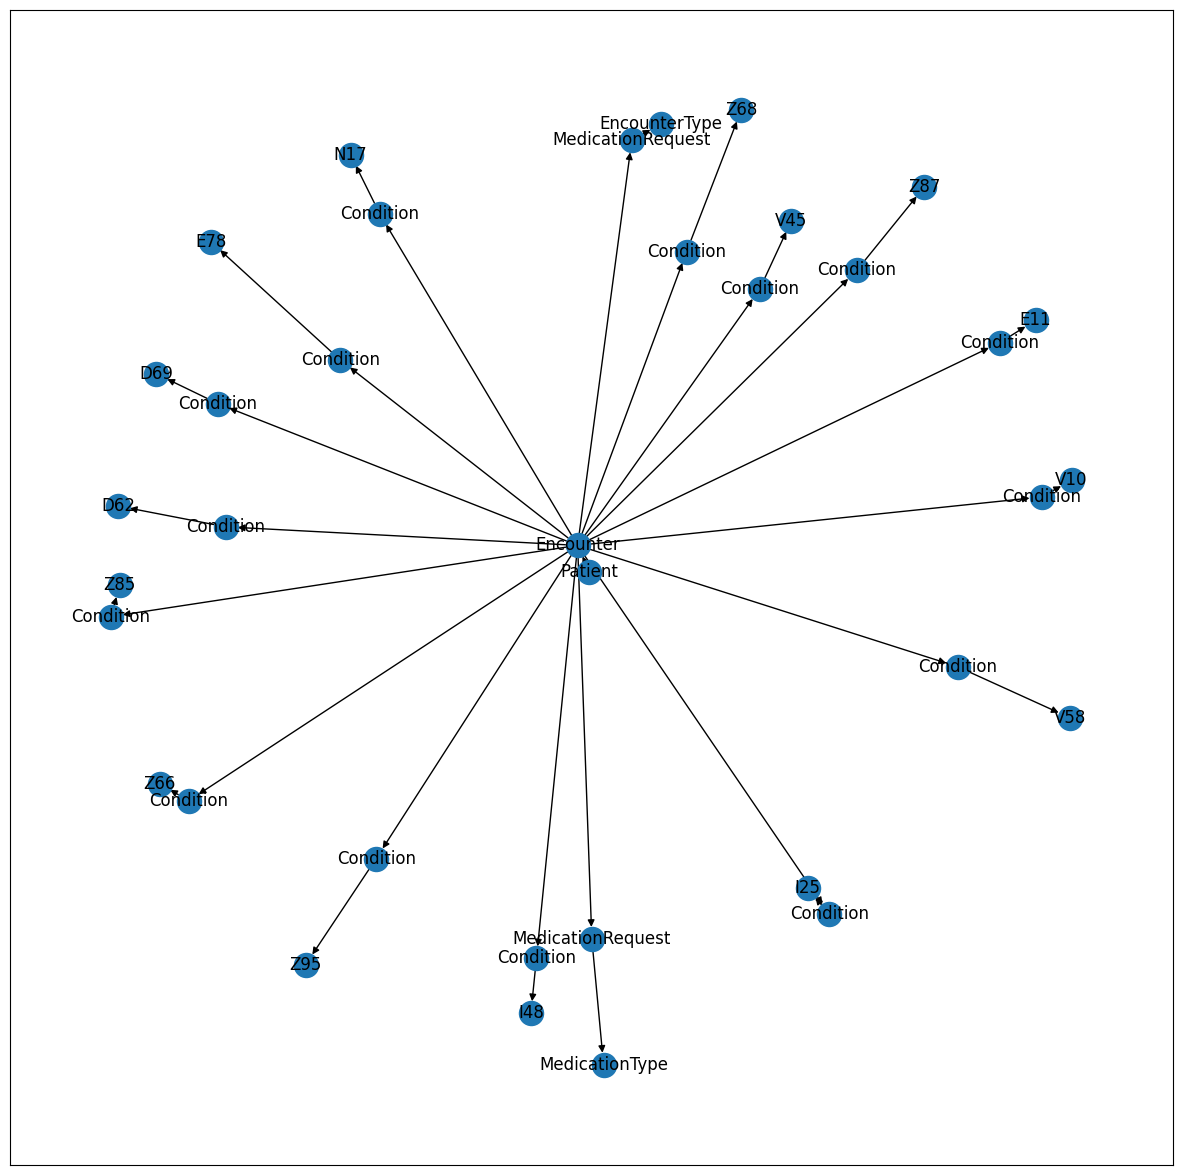

In [30]:
Gs_generated_processed = postprocess_graphs(generated_graphs[:5], mapping)
idx = 3
labels = dict()
for node in Gs_generated_processed[idx].nodes():
    labels[node] = Gs_generated_processed[idx].nodes[node]["label"]
plt.figure(1, figsize=(15, 15))
nx.draw_networkx(Gs_generated_processed[idx], labels=labels)
plt.savefig("generated_example.pdf", bbox_inches="tight")